<a href="https://colab.research.google.com/github/nasare34/ResNet50-Vision-Transformer-for-GI-Pathology-Detection/blob/main/Resnet_Kvasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Mount Google Drive & Load Dataset



In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the dataset path
dataset_path = '/content/drive/My Drive/kvasir-dataset'

In [ ]:
# Verify the contents of the dataset directory
import os
print("Files in dataset directory:")
print(os.listdir(dataset_path))

Files in dataset directory:
['ulcerative-colitis', 'dyed-lifted-polyps', 'esophagitis', 'normal-pylorus', 'polyps', 'normal-cecum', 'dyed-resection-margins', 'normal-z-line']


In [ ]:
import os

# Get class directories inside the dataset path
dataset_classes = sorted([d for d in os.listdir(dataset_path) if not d.startswith('.')])
print("Classes in dataset:", dataset_classes)


Classes in dataset: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [ ]:
import os

# Defined path
ds_store_path = os.path.join(dataset_path, ".DS_Store")

# just Checking to see if .DS_Store exists and remove it
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print(".DS_Store removed successfully!")
else:
    print("No .DS_Store file found.")


No .DS_Store file found.


#Step 2: Define Image Transformations & Load Dataset



In [ ]:
# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for ResNet50
])

# Load dataset
full_dataset = ImageFolder(root=dataset_path, transform=transform)
num_classes = len(full_dataset.classes)

# Train-Test-Validation Split (80:10:10)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Created DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} images, Validation: {len(val_dataset)} images, Test: {len(test_dataset)} images")


Train: 3319 images, Validation: 414 images, Test: 416 images


<ipython-input-9-b79b5af26f77>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=counts, palette="viridis")


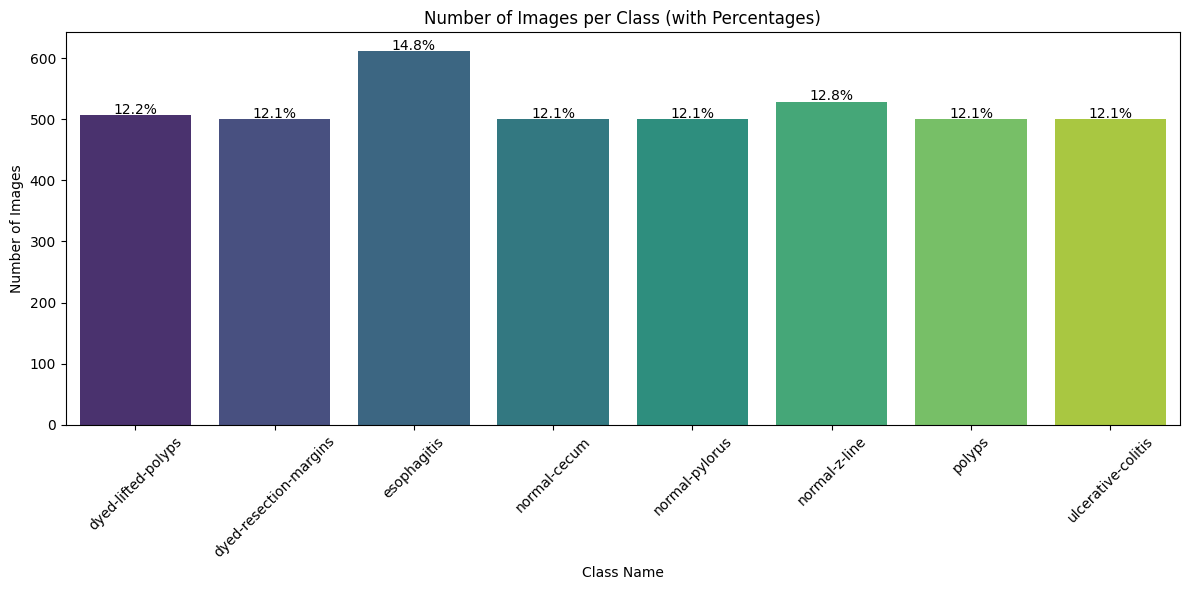

In [ ]:
from collections import Counter

# Count images per class
class_counts = Counter(full_dataset.targets)
class_names = full_dataset.classes

# Sort by class index to align names with counts
counts = [class_counts[i] for i in range(len(class_names))]
total_images = sum(counts)
percentages = [count / total_images * 100 for count in counts]

# Plot histogram with counts and percentages
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_names, y=counts, palette="viridis")

# Annotate bars with percentage
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2,
             f"{percentages[i]:.1f}%", ha='center', fontsize=10, color='black')

plt.title("Number of Images per Class (with Percentages)")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-10-693ac5574481>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=counts, palette="viridis")


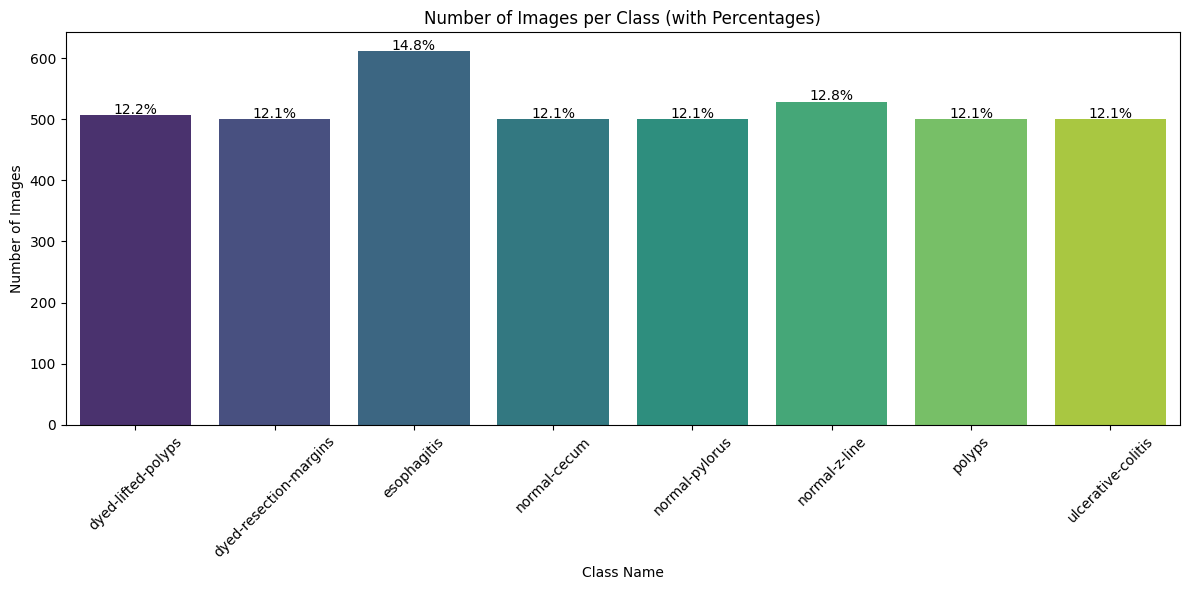

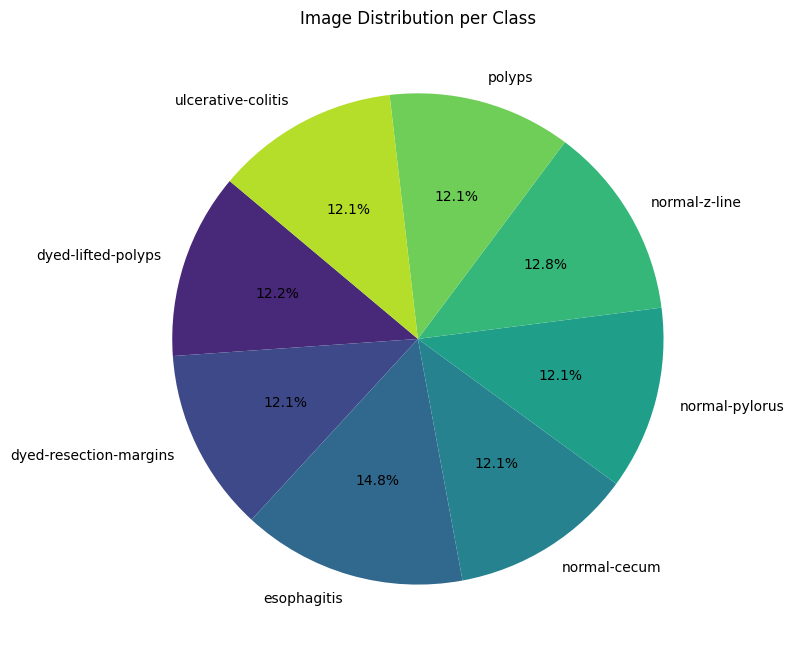


Class Distribution Table:
                 Class  Count Percentage
    dyed-lifted-polyps    507     12.22%
dyed-resection-margins    500     12.05%
           esophagitis    612     14.75%
          normal-cecum    500     12.05%
        normal-pylorus    501     12.08%
         normal-z-line    529     12.75%
                polyps    500     12.05%
    ulcerative-colitis    500     12.05%


In [ ]:
from collections import Counter
import pandas as pd

# Count images per class
class_counts = Counter(full_dataset.targets)
class_names = full_dataset.classes

# Prepare data
counts = [class_counts[i] for i in range(len(class_names))]
total_images = sum(counts)
percentages = [count / total_images * 100 for count in counts]

# ----- Histogram -----
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_names, y=counts, palette="viridis")

# Annotate with percentages
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2,
             f"{percentages[i]:.1f}%", ha='center', fontsize=10, color='black')

plt.title("Number of Images per Class (with Percentages)")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----- Pie Chart -----
plt.figure(figsize=(8, 8))
colors = sns.color_palette("viridis", len(class_names))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Image Distribution per Class")
plt.tight_layout()
plt.show()

# ----- Table Output -----
df = pd.DataFrame({
    'Class': class_names,
    'Count': counts,
    'Percentage': [f"{p:.2f}%" for p in percentages]
})
print("\nClass Distribution Table:")
print(df.to_string(index=False))


#Step 3: Load Pretrained ResNet50 & Modify for Kvasir Dataset



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loaded the pretrained ResNet50
resnet50 = models.resnet50(pretrained=True)

# Modify the final classification layer
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Move model to GPU if available
resnet50 = resnet50.to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


#Step 4: Train the Model

In [ ]:


# Load Pretrained ResNet50
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)  # Modify final layer for classification
resnet50 = resnet50.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

# Training Function
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_correct, train_total = 0, 0
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            running_loss += loss.item()

        # Calculate Training Loss and Accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate Model
        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item()

        # Calculate Validation Loss and Accuracy
        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train Model
epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(resnet50, train_loader, val_loader, epochs)


Epoch 1/30: 100%|██████████| 104/104 [22:56<00:00, 13.24s/it]


Epoch 1: Train Loss: 0.5232, Train Acc: 81.98% | Val Loss: 0.2441, Val Acc: 90.10%


Epoch 2/30: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]


Epoch 2: Train Loss: 0.2347, Train Acc: 91.65% | Val Loss: 0.2222, Val Acc: 92.27%


Epoch 3/30: 100%|██████████| 104/104 [00:59<00:00,  1.74it/s]


Epoch 3: Train Loss: 0.1832, Train Acc: 93.22% | Val Loss: 0.2639, Val Acc: 90.34%


Epoch 4/30: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]


Epoch 4: Train Loss: 0.1513, Train Acc: 94.82% | Val Loss: 0.2065, Val Acc: 92.03%


Epoch 5/30: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s]


Epoch 5: Train Loss: 0.1133, Train Acc: 96.17% | Val Loss: 0.2383, Val Acc: 91.06%


Epoch 6/30: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]


Epoch 6: Train Loss: 0.0910, Train Acc: 96.87% | Val Loss: 0.2901, Val Acc: 91.06%


Epoch 7/30: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s]


Epoch 7: Train Loss: 0.0790, Train Acc: 97.14% | Val Loss: 0.2147, Val Acc: 92.75%


Epoch 8/30: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]


Epoch 8: Train Loss: 0.0848, Train Acc: 97.20% | Val Loss: 0.2750, Val Acc: 90.82%


Epoch 9/30: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s]


Epoch 9: Train Loss: 0.0689, Train Acc: 97.53% | Val Loss: 0.1973, Val Acc: 92.75%


Epoch 10/30: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]


Epoch 10: Train Loss: 0.0404, Train Acc: 98.89% | Val Loss: 0.2327, Val Acc: 92.27%


Epoch 11/30: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]


Epoch 11: Train Loss: 0.0552, Train Acc: 98.28% | Val Loss: 0.2385, Val Acc: 92.03%


Epoch 12/30: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s]


Epoch 12: Train Loss: 0.0397, Train Acc: 98.70% | Val Loss: 0.2248, Val Acc: 93.24%


Epoch 13/30: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]


Epoch 13: Train Loss: 0.0464, Train Acc: 98.40% | Val Loss: 0.2896, Val Acc: 91.79%


Epoch 14/30: 100%|██████████| 104/104 [00:59<00:00,  1.73it/s]


Epoch 14: Train Loss: 0.0372, Train Acc: 98.73% | Val Loss: 0.2398, Val Acc: 93.00%


Epoch 15/30: 100%|██████████| 104/104 [00:59<00:00,  1.74it/s]


Epoch 15: Train Loss: 0.0354, Train Acc: 98.86% | Val Loss: 0.2340, Val Acc: 93.72%


Epoch 16/30: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]


Epoch 16: Train Loss: 0.0352, Train Acc: 98.67% | Val Loss: 0.2400, Val Acc: 93.00%


Epoch 17/30: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s]


Epoch 17: Train Loss: 0.0343, Train Acc: 99.01% | Val Loss: 0.2366, Val Acc: 93.96%


Epoch 18/30: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]


Epoch 18: Train Loss: 0.0322, Train Acc: 98.79% | Val Loss: 0.2886, Val Acc: 93.00%


Epoch 19/30: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]


Epoch 19: Train Loss: 0.0281, Train Acc: 99.16% | Val Loss: 0.3564, Val Acc: 91.30%


Epoch 20/30: 100%|██████████| 104/104 [00:59<00:00,  1.73it/s]


Epoch 20: Train Loss: 0.0446, Train Acc: 98.73% | Val Loss: 0.2788, Val Acc: 91.79%


Epoch 21/30: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]


Epoch 21: Train Loss: 0.0407, Train Acc: 98.67% | Val Loss: 0.2710, Val Acc: 93.24%


Epoch 22/30: 100%|██████████| 104/104 [01:01<00:00,  1.70it/s]


Epoch 22: Train Loss: 0.0362, Train Acc: 98.79% | Val Loss: 0.2886, Val Acc: 93.72%


Epoch 23/30: 100%|██████████| 104/104 [00:59<00:00,  1.74it/s]


Epoch 23: Train Loss: 0.0341, Train Acc: 98.95% | Val Loss: 0.2495, Val Acc: 92.75%


Epoch 24/30: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]


Epoch 24: Train Loss: 0.0303, Train Acc: 99.10% | Val Loss: 0.2586, Val Acc: 92.03%


Epoch 25/30: 100%|██████████| 104/104 [01:02<00:00,  1.68it/s]


Epoch 25: Train Loss: 0.0169, Train Acc: 99.49% | Val Loss: 0.2049, Val Acc: 94.44%


Epoch 26/30: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s]


Epoch 26: Train Loss: 0.0432, Train Acc: 98.70% | Val Loss: 0.3178, Val Acc: 91.55%


Epoch 27/30: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]


Epoch 27: Train Loss: 0.0434, Train Acc: 98.61% | Val Loss: 0.3337, Val Acc: 92.03%


Epoch 28/30: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s]


Epoch 28: Train Loss: 0.0309, Train Acc: 99.19% | Val Loss: 0.2160, Val Acc: 93.48%


Epoch 29/30: 100%|██████████| 104/104 [00:59<00:00,  1.75it/s]


Epoch 29: Train Loss: 0.0351, Train Acc: 98.67% | Val Loss: 0.2444, Val Acc: 93.48%


Epoch 30/30: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s]


Epoch 30: Train Loss: 0.0483, Train Acc: 98.34% | Val Loss: 0.2403, Val Acc: 92.75%


#Step 5: Plot Training & Validation Loss



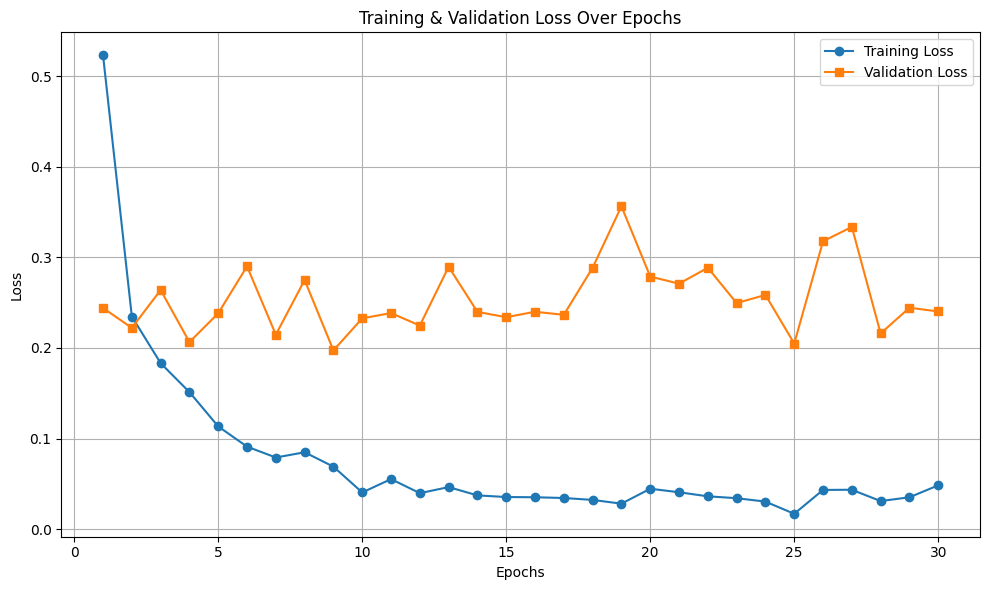

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


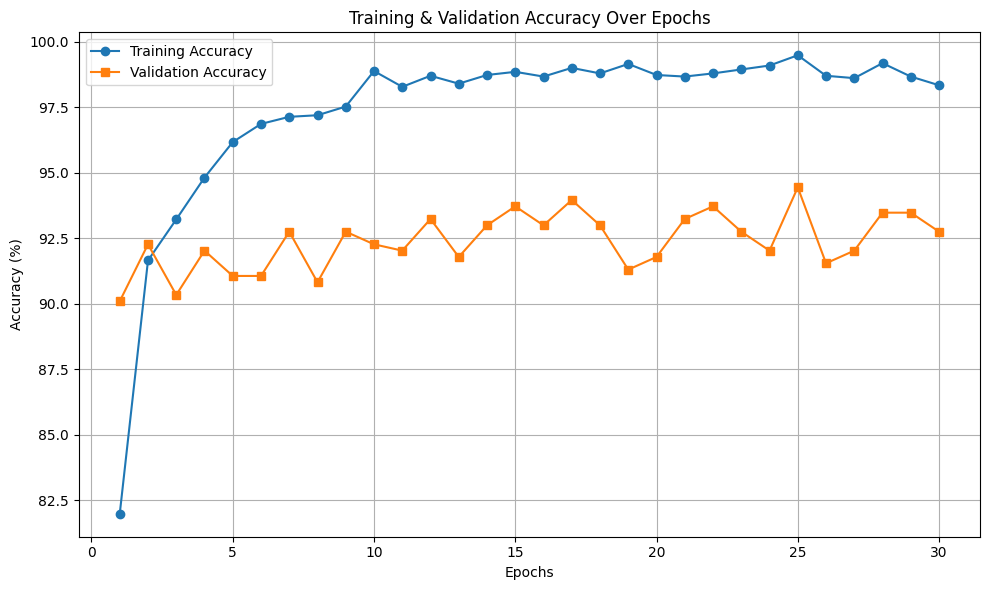

In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#6 OVERALL TEST ACCURACY

In [ ]:
def overall_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Overall Test Accuracy: {accuracy:.2f}%")

# Call this function
overall_accuracy(resnet50, test_loader)


Overall Test Accuracy: 93.27%


# 7. TEST ACCURACY CLASS-WISE

In [ ]:
import numpy as np

def class_wise_accuracy(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Class-wise Accuracy:")
    for i, class_name in enumerate(class_names):
        idxs = (y_true == i)
        correct = np.sum(y_pred[idxs] == i)
        total = np.sum(idxs)
        accuracy = 100 * correct / total if total > 0 else 0
        print(f"  {class_name}: {accuracy:.2f}% ({correct}/{total})")

# Call this function
class_wise_accuracy(resnet50, test_loader, full_dataset.classes)


Class-wise Accuracy:
  dyed-lifted-polyps: 98.04% (50/51)
  dyed-resection-margins: 93.88% (46/49)
  esophagitis: 86.44% (51/59)
  normal-cecum: 96.61% (57/59)
  normal-pylorus: 100.00% (56/56)
  normal-z-line: 86.67% (39/45)
  polyps: 76.74% (33/43)
  ulcerative-colitis: 96.30% (52/54)


#8. Classification Report and Confusion Matrix




Classification Report:

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.91      0.98      0.94        51
dyed-resection-margins       0.98      0.98      0.98        49
           esophagitis       0.88      0.90      0.89        59
          normal-cecum       0.98      1.00      0.99        59
        normal-pylorus       0.95      1.00      0.97        56
         normal-z-line       0.87      0.87      0.87        45
                polyps       1.00      0.84      0.91        43
    ulcerative-colitis       0.98      0.94      0.96        54

              accuracy                           0.94       416
             macro avg       0.94      0.94      0.94       416
          weighted avg       0.94      0.94      0.94       416



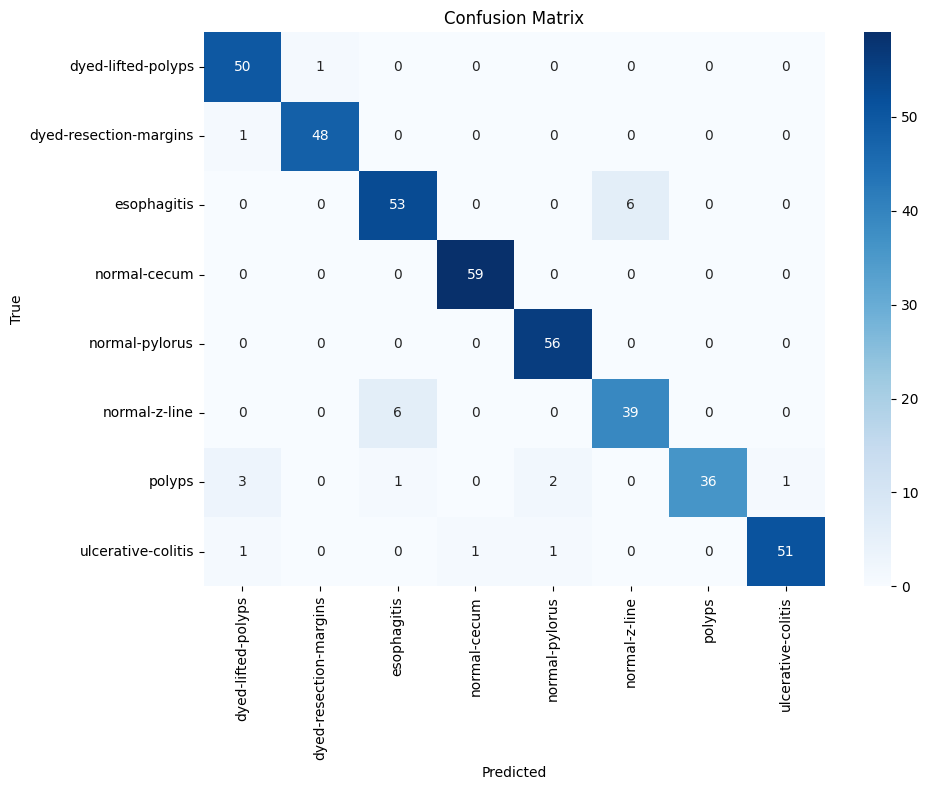

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report_and_confusion_matrix(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Call this function
classification_report_and_confusion_matrix(resnet50, test_loader, full_dataset.classes)


#FULL DATASET CONFUSION MATRIX


Classification Report:

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.95      0.99      0.97       507
dyed-resection-margins       0.99      0.97      0.98       500
           esophagitis       0.97      0.97      0.97       612
          normal-cecum       0.99      1.00      1.00       500
        normal-pylorus       0.99      0.99      0.99       501
         normal-z-line       0.97      0.98      0.97       529
                polyps       1.00      0.95      0.97       500
    ulcerative-colitis       0.98      1.00      0.99       500

              accuracy                           0.98      4149
             macro avg       0.98      0.98      0.98      4149
          weighted avg       0.98      0.98      0.98      4149



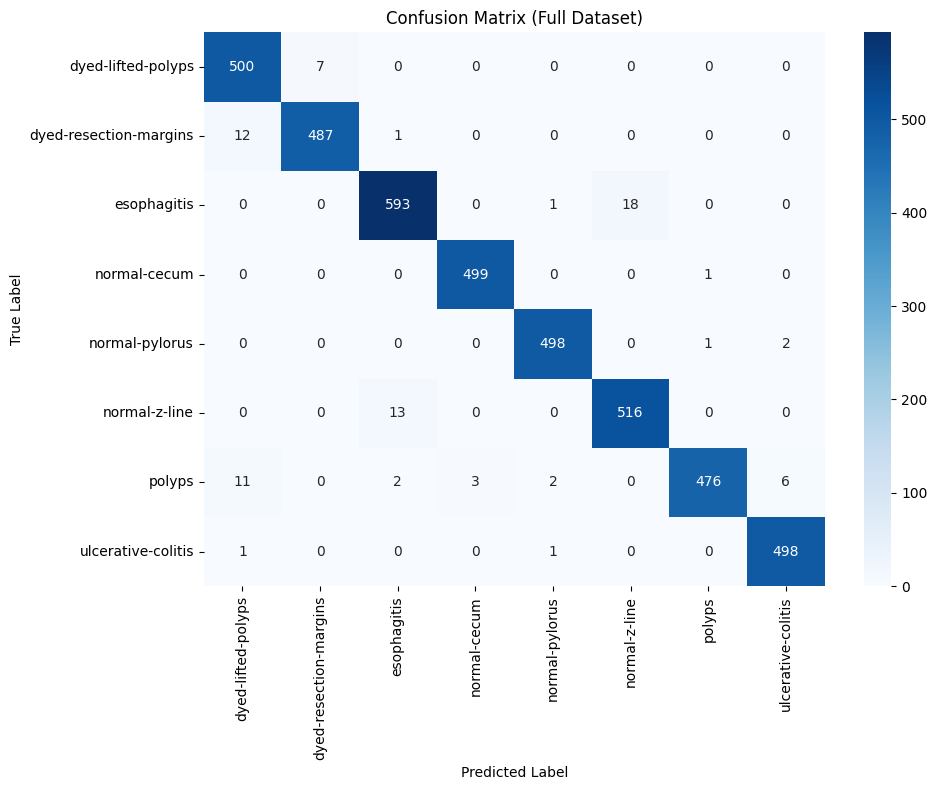

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Create DataLoader for full dataset (ensure full_dataset is defined)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def classification_report_and_confusion_matrix(model, data_loader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Full Dataset)")
    plt.tight_layout()
    plt.show()

# Run the evaluation on full dataset with your trained ResNet model
classification_report_and_confusion_matrix(resnet50, full_loader, full_dataset.classes, device)


# 9 Multi-Class ROC Curve with AUC



#ROC Curves for Multiclass

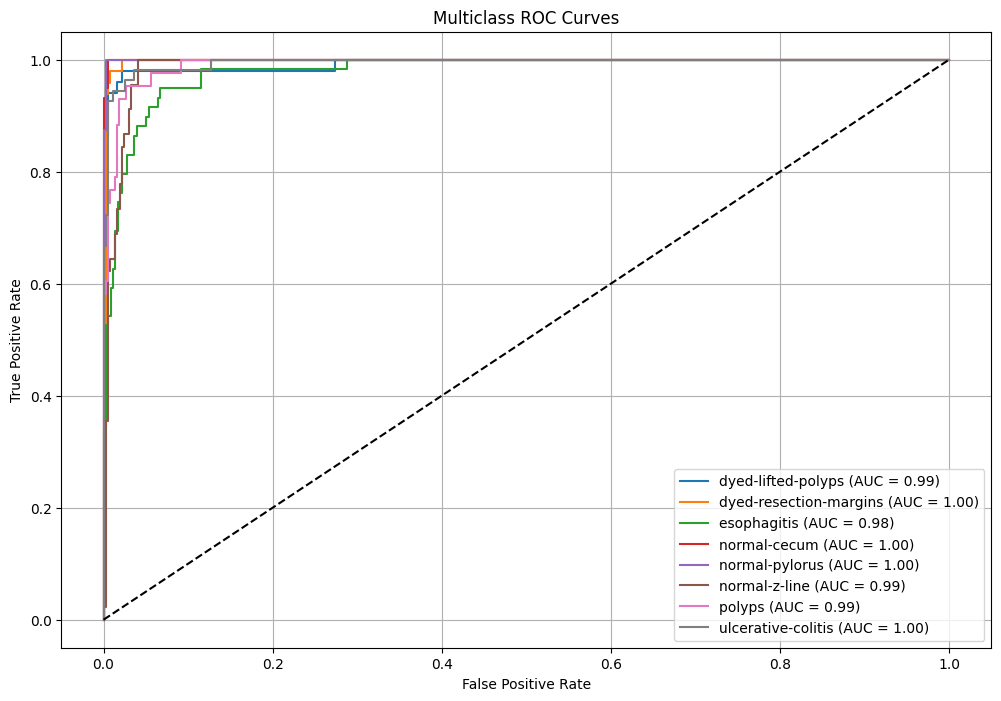

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_multiclass_roc(model, test_loader, class_names, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            y_scores.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    y_scores = np.array(y_scores)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curves")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Define class_names here, likely from the full_dataset object used previously
class_names = full_dataset.classes

# Call this function with the trained resnet50 model
plot_multiclass_roc(resnet50, test_loader, class_names, device)

#GRAD CAM

In [ ]:
pip install torchinfo


In [ ]:
from torchinfo import summary

#  input size is (batch_size=1, channels=3, height=224, width=224)
summary(resnet50, input_size=(1, 3, 224, 224), device=str(device))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 8]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
from ptflops import get_model_complexity_info
import torch



device = torch.device("cpu")
model = resnet50.to(device)
model.eval()

with torch.no_grad():
    macs, params = get_model_complexity_info(
        model,
        (3, 224, 224),
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )

print(f"Computational complexity (MACs): {macs}")
print(f"Number of parameters: {params}")


Computational complexity (MACs): 4.13 GMac
Number of parameters: 23.52 M


In [ ]:
from torchinfo import summary
import torch
import torchvision.models as models
import torch.nn as nn

#  device .:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defined my model exactly like in your code
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)  # num_classes from your dataset
resnet50 = resnet50.to(device)

#  print model summary
summary(resnet50, input_size=(1, 3, 224, 224), device=str(device))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 8]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 873.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install opencv-python-headless

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

def show_gradcam_no_cv2(img_tensor, heatmap, alpha=0.4):
    """
    img_tensor: torch.Tensor, shape (C, H, W), unnormalized input image tensor on CPU
    heatmap: numpy array, shape (H_heatmap, W_heatmap), values between 0 and 1

    Displays the GradCAM heatmap overlayed on the original image.
    """
    # Convert torch tensor to numpy image (H, W, C) and normalize 0-1
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize image to [0,1]

    # Resize heatmap to match input image size using PIL
    heatmap_img = Image.fromarray(np.uint8(255 * heatmap))  # Convert heatmap to uint8 image
    heatmap_img = heatmap_img.resize((img.shape[1], img.shape[0]), Image.BILINEAR)
    heatmap_resized = np.array(heatmap_img) / 255.0  # Normalize back to [0,1]

    # Apply matplotlib's 'jet' colormap to heatmap
    cmap = plt.get_cmap('jet')
    heatmap_color = cmap(heatmap_resized)[:, :, :3]  # Drop alpha channel, keep RGB
    heatmap_color = heatmap_color.astype(np.float32)

    # Overlay heatmap on the original image
    cam = heatmap_color * alpha + img
    cam = cam / cam.max()  # Normalize combined image to [0,1]

    # Plot the result
    plt.figure(figsize=(6,6))
    plt.imshow(cam)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()


In [ ]:
# Taking first image in batch
input_img = images[0].unsqueeze(0) # Keep this for GradCAM calculation

# Run GradCAM on it
heatmap, pred_class_idx = gradcam(input_img)

print(f"True Label: {labels[0].item()}, Predicted: {pred_class_idx}")

# Pass the original image tensor (C, H, W) to the display function
show_gradcam_no_cv2(images[0], heatmap)

gradcam.remove_hooks()

NameError: name 'gradcam' is not defined